### Data Augmentation (75%) of Each Data Split Independantly
This section defines the augmentation methods (synonym replacement and contextual embedding) applied to 75% of the definitional sentences.

In [1]:
import os
import pandas as pd
from sklearn.utils import shuffle
from tqdm import tqdm
import spacy
import nlpaug.augmenter.word as naw
from nltk.corpus import wordnet

spacy_nlp = spacy.load("en_core_web_sm")

def synonym_augmenter(text):
    """
    Augments text using WordNet synonyms for nouns, verbs, adjectives, and adverbs.
    """
    doc = spacy_nlp(text)
    augmented_text = []
    for token in doc:
        if token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV'}:
            synonyms = wordnet.synsets(token.text)
            if synonyms:
                synonym = synonyms[0].lemmas()[0].name() 
                augmented_text.append(synonym.replace('_', ' '))
            else:
                augmented_text.append(token.text)
        else:
            augmented_text.append(token.text)
    return " ".join(augmented_text)

contextual_aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")

# Augmentation Function
def augment_split(data, split_name, augmentation_percentage=0.75):
    """
    Augments a data split independently with specified augmentation percentage.
    """
    definition_data = data[data['definition_sentence'] == 1]
    non_definition_data = data[data['definition_sentence'] == 0]

    # Sampling of 75% of definitional sentences for playing around augmentation
    sampled_definitions = definition_data.sample(frac=augmentation_percentage, random_state=42)

    augmented_sentences = []
    for text in tqdm(sampled_definitions['sentence_original'], desc=f"Augmenting {split_name} definitions"):
    
        augmented_sentences.append(contextual_aug.augment(text))
        augmented_sentences.append(synonym_augmenter(text))

    augmented_definitions = pd.DataFrame({
        'sentence_original': augmented_sentences,
        'definition_sentence': 1
    })

    # Combining original and augmented data
    combined_data = pd.concat([non_definition_data, definition_data, augmented_definitions], ignore_index=True)
    return combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

train_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/train_split_original.csv'
val_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/val_split_original.csv'
test_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/test_split_original.csv'

output_dir = '/home/roland/Projects/saras_folder/Data_Splitting/75%_Aug'
os.makedirs(output_dir, exist_ok=True)

# Augmentation of each split separatel
for split_name, file_path in zip(
    ["Train", "Validation", "Test"],
    [train_split_path, val_split_path, test_split_path]
):
    print(f"Processing {split_name} Split...")
    split_data = pd.read_csv(file_path)
    augmented_data = augment_split(split_data, split_name, augmentation_percentage=0.75)

    output_path = os.path.join(output_dir, f"{split_name.lower()}_split_augmented_75.csv")
    augmented_data.to_csv(output_path, index=False)
    print(f"Augmented {split_name} Split saved to: {output_path}")


/home/roland/Projects/saras_folder/myvenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Processing Train Split...


Augmenting Train definitions: 100%|██████████| 1024/1024 [04:44<00:00,  3.60it/s]


Augmented Train Split saved to: /home/roland/Projects/saras_folder/Data_Splitting/75%_Aug/train_split_augmented_75.csv
Processing Validation Split...


Augmenting Validation definitions: 100%|██████████| 256/256 [01:09<00:00,  3.67it/s]


Augmented Validation Split saved to: /home/roland/Projects/saras_folder/Data_Splitting/75%_Aug/validation_split_augmented_75.csv
Processing Test Split...


Augmenting Test definitions: 100%|██████████| 320/320 [01:22<00:00,  3.87it/s]

Augmented Test Split saved to: /home/roland/Projects/saras_folder/Data_Splitting/75%_Aug/test_split_augmented_75.csv


#### Augmentated Data Validation (75%): Class Distribution and Checking Sizes (Before and After Augmentation Applied).

In [2]:
import os
import pandas as pd

original_dir = '/home/roland/Projects/saras_folder/Data_Splitting'
augmented_dir = '/home/roland/Projects/saras_folder/Data_Splitting/75%_Aug'

split_files = {
    "Train": "train_split_original.csv",
    "Validation": "val_split_original.csv",
    "Test": "test_split_original.csv"
}

augmented_files = {
    "Train": "train_split_augmented_75.csv",
    "Validation": "validation_split_augmented_75.csv",
    "Test": "test_split_augmented_75.csv"
}

print("Comparison of Record Counts Before and After Augmentation:\n")

for split_name in split_files.keys():
   
    original_path = os.path.join(original_dir, split_files[split_name])
    augmented_path = os.path.join(augmented_dir, augmented_files[split_name])

    print(f"{split_name} Split:")

    if os.path.exists(original_path):
        original_data = pd.read_csv(original_path)
        total_original = len(original_data)
        def_original = original_data[original_data['definition_sentence'] == 1].shape[0]
        non_def_original = original_data[original_data['definition_sentence'] == 0].shape[0]

        print(f"  Before Augmentation:")
        print(f"    Total Records: {total_original}")
        print(f"    Definitional Sentences: {def_original}")
        print(f"    Non-Definitional Sentences: {non_def_original}")
    else:
        print(f"  Original file not found at {original_path}")

    if os.path.exists(augmented_path):
        augmented_data = pd.read_csv(augmented_path)
        total_augmented = len(augmented_data)
        def_augmented = augmented_data[augmented_data['definition_sentence'] == 1].shape[0]
        non_def_augmented = augmented_data[augmented_data['definition_sentence'] == 0].shape[0]

        print(f"  After Augmentation:")
        print(f"    Total Records: {total_augmented}")
        print(f"    Definitional Sentences: {def_augmented}")
        print(f"    Non-Definitional Sentences: {non_def_augmented}")
    else:
        print(f"  Augmented file not found at {augmented_path}")

    print() 


Comparison of Record Counts Before and After Augmentation:

Train Split:
  Before Augmentation:
    Total Records: 19996
    Definitional Sentences: 1365
    Non-Definitional Sentences: 18631
  After Augmentation:
    Total Records: 22044
    Definitional Sentences: 3413
    Non-Definitional Sentences: 18631

Validation Split:
  Before Augmentation:
    Total Records: 4999
    Definitional Sentences: 341
    Non-Definitional Sentences: 4658
  After Augmentation:
    Total Records: 5511
    Definitional Sentences: 853
    Non-Definitional Sentences: 4658

Test Split:
  Before Augmentation:
    Total Records: 6249
    Definitional Sentences: 426
    Non-Definitional Sentences: 5823
  After Augmentation:
    Total Records: 6889
    Definitional Sentences: 1066
    Non-Definitional Sentences: 5823



### Partial Augmentation Level (75%) Model Training and Evaluation

#### Overview
Training and evaluation of the model using 1:5 ratio of definitions to non-definitions over 75% Augmented data. The training is done using the MPNet embedding model (`paraphrase-mpnet-base-v2`)and the Setfit Framework

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
<ipython-input-3-48e98153092b>:54: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(
Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset
Currently using DataParallel (DP) for multi-gpu training, while DistributedDataParallel (DDP) is recommended for faster training. See https://sbert.net/docs/sentence_transformer/training/distributed.html for more information.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Map: 100%|██████████| 20478/20478 [00:03<00:00, 5583.03 examples/s]


Starting training with a 1:5 ratio of definitional to non-definitional sentences...

Epoch 1/3


***** Running training *****
  Num unique pairs = 819120
  Batch size = 16
  Num epochs = 1


Step,Training Loss
1,0.369100
50,0.350600
100,0.301000
150,0.266800
200,0.234000
250,0.197300
300,0.156900
350,0.140500
400,0.138200
450,0.118000


Validation Metrics after Epoch 1:
  AUC-ROC: 0.8979
  Precision: 0.9188
  Recall: 0.8089
  F1-Score: 0.8603
  F2-Score: 0.8287
Model saved at: /home/roland/Projects/saras_folder/Data_Splitting/75%-1-5-ratio/train_model_epoch_1

Epoch 2/3


***** Running training *****
  Num unique pairs = 819120
  Batch size = 16
  Num epochs = 1


Step,Training Loss
1,0.002900
50,0.005700
100,0.007000
150,0.003700
200,0.004200
250,0.007500
300,0.004100
350,0.003600
400,0.003200
450,0.006700


Validation Metrics after Epoch 2:
  AUC-ROC: 0.9074
  Precision: 0.9089
  Recall: 0.8300
  F1-Score: 0.8676
  F2-Score: 0.8447
Model saved at: /home/roland/Projects/saras_folder/Data_Splitting/75%-1-5-ratio/train_model_epoch_2

Epoch 3/3


***** Running training *****
  Num unique pairs = 819120
  Batch size = 16
  Num epochs = 1


Step,Training Loss
1,0.002800
50,0.004500
100,0.006000
150,0.003300
200,0.004400
250,0.005700
300,0.003400
350,0.003200
400,0.003100
450,0.004800


Validation Metrics after Epoch 3:
  AUC-ROC: 0.9054
  Precision: 0.9062
  Recall: 0.8265
  F1-Score: 0.8645
  F2-Score: 0.8413
Model saved at: /home/roland/Projects/saras_folder/Data_Splitting/75%-1-5-ratio/train_model_epoch_3


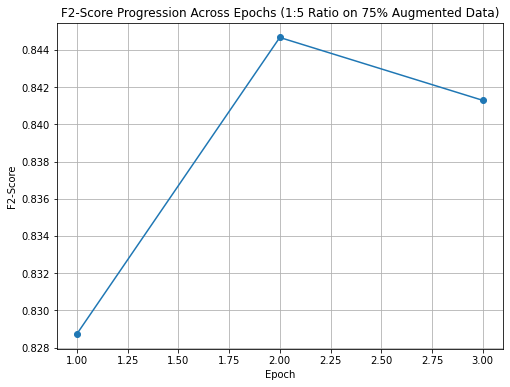

F2-Score progression chart saved at: /home/roland/Projects/saras_folder/Data_Splitting/75%-1-5-ratio/f2_scores_progression.png
Final model saved at: /home/roland/Projects/saras_folder/Data_Splitting/75%-1-5-ratio/final_trained_model

Test Set Metrics (Final Evaluation):
AUC-ROC: 0.9099
Precision: 0.8904
Recall: 0.8386
F1-Score: 0.8638
F2-Score: 0.8485


: 

In [3]:
import os
import pandas as pd
from sklearn.utils import shuffle
from datasets import Dataset
from setfit import SetFitModel, SetFitTrainer
from sentence_transformers.losses import CosineSimilarityLoss
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, fbeta_score
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"

train_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/75%_Aug/train_split_augmented_75.csv'
val_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/75%_Aug/validation_split_augmented_75.csv'
test_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/75%_Aug/test_split_augmented_75.csv'

train_data = pd.read_csv(train_split_path)
val_data = pd.read_csv(val_split_path)
test_data = pd.read_csv(test_split_path)

# Separating sentences
def_data = train_data[train_data['definition_sentence'] == 1]
non_def_data = train_data[train_data['definition_sentence'] == 0]

# (1:5) ratio of definitions to non-definitions
num_definitions = len(def_data)
num_required_non_definitions = num_definitions * 5

# Randomly sampling non-definitions to match the 1:5 ratio
sampled_non_definitions = non_def_data.sample(
    n=min(num_required_non_definitions, len(non_def_data)),
    random_state=42 
)

# Combining sentences
balanced_train_data = pd.concat([def_data, sampled_non_definitions])

# Shuffling data for randomization
balanced_train_data = shuffle(balanced_train_data, random_state=42)

train_dataset = Dataset.from_pandas(balanced_train_data)
val_dataset = Dataset.from_pandas(val_data)

epoch_save_dir = "/home/roland/Projects/saras_folder/Data_Splitting/75%-1-5-ratio"
os.makedirs(epoch_save_dir, exist_ok=True)

model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    loss_class=CosineSimilarityLoss,
    batch_size=16,
    num_iterations=20,
    column_mapping={"sentence_original": "text", "definition_sentence": "label"}
)

f2_scores = []

num_epochs = 3 
print("Starting training with a 1:5 ratio of definitional to non-definitional sentences...")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    trainer.train() 

    # Evaluating on the validation set
    val_labels = val_data['definition_sentence'].tolist()
    val_predictions = trainer.model.predict(val_data['sentence_original'].tolist())
    
    f2 = fbeta_score(val_labels, val_predictions, beta=2)
    val_auc = roc_auc_score(val_labels, val_predictions)
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='binary')

    print(f"Validation Metrics after Epoch {epoch + 1}:")
    print(f"  AUC-ROC: {val_auc:.4f}")
    print(f"  Precision: {val_precision:.4f}")
    print(f"  Recall: {val_recall:.4f}")
    print(f"  F1-Score: {val_f1:.4f}")
    print(f"  F2-Score: {f2:.4f}")
    
    f2_scores.append(f2)

    model_save_path_epoch = os.path.join(epoch_save_dir, f"train_model_epoch_{epoch + 1}")
    model.save_pretrained(model_save_path_epoch)
    print(f"Model saved at: {model_save_path_epoch}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(f2_scores) + 1), f2_scores, marker='o')
plt.xlabel("Epoch")
plt.ylabel("F2-Score")
plt.title("F2-Score Progression Across Epochs (1:5 Ratio on 75% Augmented Data)")
plt.grid(True)
progress_chart_path = os.path.join(epoch_save_dir, "f2_scores_progression.png")
plt.savefig(progress_chart_path)
plt.show()
print(f"F2-Score progression chart saved at: {progress_chart_path}")

final_model_path = os.path.join(epoch_save_dir, "final_trained_model")
model.save_pretrained(final_model_path)
print(f"Final model saved at: {final_model_path}")

# Evaluating on the test set
test_labels = test_data['definition_sentence'].tolist()
test_predictions = model.predict(test_data['sentence_original'].tolist())

test_auc = roc_auc_score(test_labels, test_predictions)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='binary')
test_f2 = fbeta_score(test_labels, test_predictions, beta=2)

print("\nTest Set Metrics (Final Evaluation):")
print(f"AUC-ROC: {test_auc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"F2-Score: {test_f2:.4f}")


#### Graphs and Performance Visualization

In [1]:
import os
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, fbeta_score
from datasets import Dataset
from setfit import SetFitModel

os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"

val_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/75%_Aug/validation_split_augmented_75.csv'
test_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/75%_Aug/test_split_augmented_75.csv'
model_dir = '/home/roland/Projects/saras_folder/Data_Splitting/75%_Aug/75%-1-5-ratio'

val_data = pd.read_csv(val_split_path)
test_data = pd.read_csv(test_split_path)

epoch_metrics = []
num_epochs = 3

for epoch in range(1, num_epochs + 1):
    model_path = os.path.join(model_dir, f"train_model_epoch_{epoch}")
    model = SetFitModel.from_pretrained(model_path)
    
    val_labels = val_data['definition_sentence'].tolist()
    val_predictions = model.predict(val_data['sentence_original'].tolist())
    
    val_auc = roc_auc_score(val_labels, val_predictions)
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='binary')
    val_f2 = fbeta_score(val_labels, val_predictions, beta=2)
    
    epoch_metrics.append({
        "Epoch": epoch,
        "AUC-ROC": val_auc,
        "Precision": val_precision,
        "Recall": val_recall,
        "F1-Score": val_f1,
        "F2-Score": val_f2
    })
final_model_path = os.path.join(model_dir, "final_trained_model")
final_model = SetFitModel.from_pretrained(final_model_path)
test_labels = test_data['definition_sentence'].tolist()
test_predictions = final_model.predict(test_data['sentence_original'].tolist())

test_auc = roc_auc_score(test_labels, test_predictions)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='binary')
test_f2 = fbeta_score(test_labels, test_predictions, beta=2)

epoch_metrics.append({
    "Epoch": "Test Split",
    "AUC-ROC": test_auc,
    "Precision": test_precision,
    "Recall": test_recall,
    "F1-Score": test_f1,
    "F2-Score": test_f2
})

metrics_df = pd.DataFrame(epoch_metrics)
print(metrics_df)


/home/roland/Projects/saras_folder/myvenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


        Epoch   AUC-ROC  Precision    Recall  F1-Score  F2-Score
0           1  0.897907   0.918775  0.808910  0.860349  0.828729
1           2  0.907385   0.908858  0.830012  0.867647  0.844667
2           3  0.905411   0.906170  0.826495  0.864500  0.841289
3  Test Split  0.909879   0.890438  0.838649  0.863768  0.848519


#### Plotting the Confusion Matrix

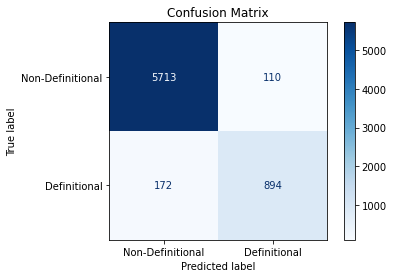


Final Model - Test Set Metrics:
AUC-ROC: 0.9099
Precision: 0.8904
Recall: 0.8386
F1-Score: 0.8638
F2-Score: 0.8485


: 

In [4]:
import os
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, fbeta_score, confusion_matrix, ConfusionMatrixDisplay
from setfit import SetFitModel
import matplotlib.pyplot as plt

test_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/75%_Aug/test_split_augmented_75.csv'
final_model_path = '/home/roland/Projects/saras_folder/Data_Splitting/75%_Aug/75%-1-5-ratio/final_trained_model'

test_data = pd.read_csv(test_split_path)

final_model = SetFitModel.from_pretrained(final_model_path)

test_labels = test_data['definition_sentence'].tolist()
test_predictions = final_model.predict(test_data['sentence_original'].tolist())

test_auc = roc_auc_score(test_labels, test_predictions)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='binary')
test_f2 = fbeta_score(test_labels, test_predictions, beta=2)

# Plotting confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Definitional", "Definitional"])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()

print("\nFinal Model - Test Set Metrics:")
print(f"AUC-ROC: {test_auc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"F2-Score: {test_f2:.4f}")


#### ROC Curve and AUC-ROC Evaluation

Loading trained model...
Generating probabilities for the test set...

Test Set Metrics (Final Evaluation):
AUC-ROC: 0.9058
Precision: 0.8904
Recall: 0.8386
F1-Score: 0.8638
F2-Score: 0.8485


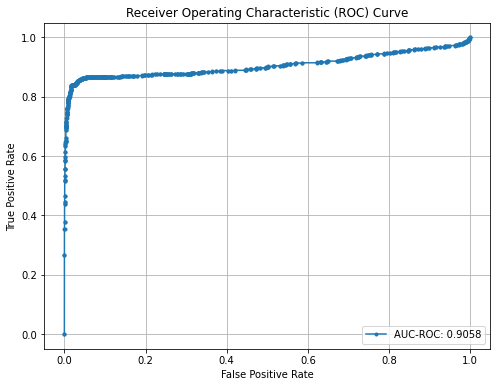

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_fscore_support, fbeta_score
import matplotlib.pyplot as plt
from setfit import SetFitModel

model_path = '/home/roland/Projects/saras_folder/Data_Splitting/75%_Aug/75%-1-5-ratio/final_trained_model'
test_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/75%_Aug/test_split_augmented_75.csv'

test_data = pd.read_csv(test_split_path)
print("Loading trained model...")
model = SetFitModel.from_pretrained(model_path)
test_labels = test_data['definition_sentence'].tolist()
test_sentences = test_data['sentence_original'].tolist()
# probabilities for the test set
print("Generating probabilities for the test set...")
test_probabilities = model.predict_proba(test_sentences)
# Extract probabilities for the positive class
positive_probabilities = [prob[1] for prob in test_probabilities]

test_auc = roc_auc_score(test_labels, positive_probabilities)
test_predictions = [1 if prob > 0.5 else 0 for prob in positive_probabilities]
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='binary')
test_f2 = fbeta_score(test_labels, test_predictions, beta=2)

print("\nTest Set Metrics (Final Evaluation):")
print(f"AUC-ROC: {test_auc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"F2-Score: {test_f2:.4f}")

# Computation of the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, positive_probabilities)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC: {test_auc:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
